# Code Thesis Bachelor Econometrics
**Algorithmic Collusion Under Asymmetric Pricing Frequencies**

Name: *Anouck Rietveld*

Student Number: *11231424*

Supervisor: *Dr. M. A. L. Koster*

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Necessary Libraries**

In [3]:
import random
from pprint import pprint
import numpy as np
from numpy.random import choice
from collections import defaultdict
import pandas as pd
import math
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sn

**Calculate Different Thetas for Different Learning Periods**

For different learning periods, different theta's have to be used to ensure a certain level of exploration throughout the game. These necessary theta's are calculated in the cell below.

In [4]:
T = [100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]

T_array = np.array(T)
halve_T_array = 0.5 * T_array

epsilon_halve_t = 0.001
theta = 1 - epsilon_halve_t**(1/halve_T_array)
theta

array([1.38145563e-04, 6.90751670e-05, 4.60506415e-05, 3.45381799e-05,
       2.76306394e-05, 2.30255858e-05, 1.97362489e-05, 1.72692391e-05,
       1.53504495e-05, 1.38154151e-05])

**The Simulation Game**


In the cell below the simulation game is programmed. A class for the game itself is created and a class for both firms with their properties is created. In the end of the cell CSV files are created from the game on which the analyses are conducted. 

In [18]:
# Creation of the game class
class RepeatedGame:
    def __init__(self, n_periods, firms):
        self.n_periods = n_periods
        self.firms = firms
    
    def __str__(self):
        return f"game: {self.n_periods} periods"
    
    def calculate_profit(self, price1, price2):
      # Calculating the profit based on the prices chosen by both firms
        if price1 < price2:
            profit1 = price1 * (1-price1)
            profit2 = 0
        elif price1 == price2:
            profit1 = 0.5 * price1 * (1-price1)
            profit2 = 0.5 * price2 * (1-price2)
        else:
            profit1 = 0
            profit2 = price2 * (1-price2)
        return profit1, profit2 
    
    def play(self):
      # The rules of the game
        # Initiate the prices and profits at the beginning of the game to 0
        all_prices = [[0,0]]
        all_profits = [[0,0]]
        
        # Loop over the number of periods the game is played
        for time in trange(self.n_periods):
            prices = []
            self.p = np.random.random()
            
            # Loop for every period over both firms, their turns in which they can choose their price
            for teller, firm in enumerate(self.firms):
                last_prices = all_prices[-1]
                # Check if the firm has a turn based on its frequency
                outcome = firm.turn_check(time, self.p) 
                if outcome == True:
                  # The firm is allowed to do an action / change its price, when the frequency matches the period the game is in
                  prices.append(firm.action(state=last_prices))
                else:
                  # If it is not the firms turn, it keeps the price last chosen
                  prices.append(last_prices[teller])
            
            all_prices.append(prices)
            price1, price2 = prices
            
            # Calculate the profits based on the prices of both firms
            profits = self.calculate_profit(price1, price2)    
            all_profits.append(profits)
            
            # Only update the Q-table of both firms when it is their turn, therefore check first whether the firm did an action in this period
            for firm, profit in zip(self.firms, profits):
                outcome = firm.turn_check(time, self.p)
                if outcome == True: 
                    # Update the Q-table in case the firm did an action this period
                    firm.update_q_table(profit, new_state=prices) 
            
        self.all_prices = all_prices
        self.all_profits = all_profits
            
class Firm:
    def __init__(self, *, period, theta, deviation_time = None, offset=0, stochastic = None):
        self.stochastic = stochastic 
        self.offset = offset
        self.period = period
        self.q_table = {}
        number_of_price_intervals = 6
        self.list_prices = [k/number_of_price_intervals for k in range(number_of_price_intervals +1)]
        self.time = 0
        self.theta = theta
        self.deviation = False
        self.deviation_time = deviation_time
        
    def turn_check(self, time, p):
      # Method that checks whether the firm can do an action in a specific period
        # When there is chosen for stochastic frequencies, this part of the method checks whether the firm can do its action
        if self.stochastic: 
            part = 1/self.period
            if p < part:
                return True
            else:
                return False
        else: 
          # When there are normal frequencies, with the modulo method there is checked whether the firm can do its action
            if (time+self.offset)%self.period == 0:
                return True
            else:
                return False
        
    def action(self, state):
      # Method that does the action of the firm / chooses the price from the price vector. Furthermore the deviation is described here. 
        self.state = state
        if self.deviation_time and self.time > (self.deviation_time-1) and not self.deviation:
          # When the firm has to deviate at a certain time it ends up here and is forced to choose the price 1/6
            action = self.list_prices[1]
            self.deviation = True
        else:
          # When the firm is not deviating it chooses its action according to the policy function method described below
            action = self.policy_function()

        self.chosen_action = action
        self.time += self.period
        return action
    
    def policy_function(self): 
      # Method that chooses the action / price of the firm based on the epsilon greedy policy
        n_actions = len(self.list_prices)
        epsilon = (1 - self.theta)**(self.time)
        if tuple(self.state) in self.q_table: 
          # Check if the state already exists in the Q-table, then choose a random action and the best response action
            random_action = np.random.choice(self.list_prices)
            greedy_action = max(self.q_table[tuple(self.state)], key = self.q_table[tuple(self.state)].get) 
            if greedy_action == 0.0 or 0:
                action = np.random.choice(self.list_prices)
            else:
              # Choose the action based with weigths epsilon and (1 - epsilon) for respectively the random and greedy action
                action = np.random.choice([random_action,greedy_action],p=[epsilon,1-epsilon])
        else:
          # If the state is not yet in the Q-table, just take a random action / price from the price vector
            action = np.random.choice(self.list_prices)
        return action

    def update_q_table(self, profit, new_state):
      # Method that updates the Q-table
        alpha = 0.3
        gamma = 0.95

        if tuple(self.state) not in self.q_table: 
          # Check if the current state is not in the Q-table, then create that state and set all values to 0
            self.q_table[tuple(self.state)] = {price: 0 for price in self.list_prices}
        
        if tuple(new_state) not in self.q_table:
          # Check if the new state is not in the Q-table, then create that state and set all values to 0
            self.q_table[tuple(new_state)] = {price: 0 for price in self.list_prices}
        
        # Update Q-table
        next_state_q_table = self.q_table[tuple(new_state)]
        values_next_state_q_table = next_state_q_table.values()
        max_next_state_q_table = max(values_next_state_q_table)
        update = profit + gamma * max_next_state_q_table - self.q_table[tuple(self.state)][self.chosen_action]
        self.q_table[tuple(self.state)][self.chosen_action] += alpha * update

stacked_all_prices = []
stacked_all_profits = []
stacked_final_profitability1 = []
stacked_final_profitability2 = []
stacked_all_q_tables_firm1 = []
stacked_all_q_tables_firm2 = []

# Play the game for a certain amount of times, where the firms have specific characteristics that can be changed
for runs in range(300):
    firm1 = Firm(period = 5, theta = theta[2], deviation_time = None, offset = 0, stochastic = None)
    firm2 = Firm(period = 2, theta = theta[2], deviation_time = None, offset = 0, stochastic = None) 
    firms = [firm1, firm2]
    game = RepeatedGame(300000, firms)
    game.play()
    
    # Create CSV files
    a = pd.DataFrame(game.all_prices, columns = ["Prices Firm 1", "Prices Firm 2"])
    b = pd.DataFrame(game.all_profits, columns = ["Profits Firm 1", "Profits Firm 2"])
    
    #c = pd.DataFrame.from_dict(firm1.q_table, orient = 'index').sort_index()
    #d = dataframe_firm2 = pd.DataFrame.from_dict(firm2.q_table, orient = 'index').sort_index()
    
    a.merge(b, left_index = True, right_index = True).to_csv(f"/content/drive/MyDrive/stochastic_files/Data_Run{runs+1}.csv")
    #c.merge(d, left_index = True, right_index = True).to_csv(f"/content/drive/MyDrive/Colab Notebooks/Q_table_Run{runs+10}.csv")

100%|██████████| 300000/300000 [00:16<00:00, 17647.25it/s]


**Retrieve Data From Baseline Simulation**

In [ ]:
# Get Data From Baseline Files
stacked_data = []
stacked_q_tables = []
stacked_final_profitability_firm1 = []
stacked_final_profitability_firm2 = []

for run in trange(300):
  data_runs = pd.read_csv(f"/content/drive/MyDrive/baseline_files/Data_Run{run+1}.csv").drop(columns = ["Unnamed: 0"])
  stacked_data.append(data_runs)

  data_runs_q_tables = pd.read_csv(f"/content/drive/MyDrive/baseline_files/Q_Tables_Run{run+1}.csv").drop(columns = ["Unnamed: 0"])
  stacked_q_tables.append(data_runs_q_tables)

  # Calculate Final Profitability for every run
  final_profitability_firm1 = np.mean(data_runs[-1000:], axis = 0)[2]
  stacked_final_profitability_firm1.append(final_profitability_firm1)

  final_profitability_firm2 = np.mean(data_runs[-1000:], axis = 0)[3]
  stacked_final_profitability_firm2.append(final_profitability_firm2)

# Calculate the average out of all runs for the prices and profits and the Q-tables
average_data = np.mean(stacked_data, axis = 0)
del stacked_data

average_q_tables = np.mean(stacked_q_tables, axis = 0)
del stacked_q_tables

100%|██████████| 300/300 [03:21<00:00,  1.49it/s]


**Create Bar Plot For Final Profitability**

91
209


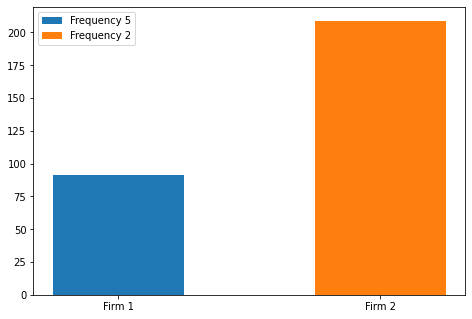

In [ ]:
count_highest_profitability_firm1 = sum(x > y for x,y in zip(stacked_final_profitability_firm1, stacked_final_profitability_firm2))
print(count_highest_profitability_firm1)
count_highest_profitability_firm2 = 300 - count_highest_profitability_firm1
print(count_highest_profitability_firm2)

# Creat Bar Plot Highest Profitability
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.bar(x= 'Firm 1', height=count_highest_profitability_firm1, width=0.5, label='Frequency 5')
plt.bar(x= 'Firm 2', height=count_highest_profitability_firm2, width=0.5, label='Frequency 2')
plt.legend()

fig.savefig(f"/content/drive/MyDrive/images/baseline/baseline_final_profitability.png", dpi=300, bbox_inches = "tight")

**Create Heatmap From Averages**

In [ ]:
# Delete first column
average_q_tables_2 = np.delete(average_q_tables, 0, axis = 1)

# split into two to get both average q_tables
average_q_table_1, average_q_table_2 = np.hsplit(average_q_tables_2,2)

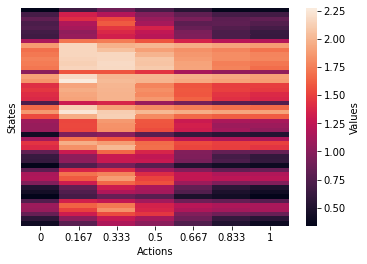

In [ ]:
# Create Heatmap Average Q-table Firm 1
x_axis_labels = [0, 0.167, 0.333, 0.5, 0.667, 0.833, 1] # labels for x-axis
y_axis_labels = []

dataframe_average_q_table_1 = pd.DataFrame(average_q_table_1)
heatmap_firm1 = sn.heatmap(dataframe_average_q_table_1, xticklabels=x_axis_labels, yticklabels = y_axis_labels)
heatmap_firm1.set_xlabel('Actions', fontsize=10)
heatmap_firm1.set_ylabel('States', fontsize=10)
heatmap_firm1.collections[0].colorbar.set_label("Values")
plt.savefig(f"/content/drive/MyDrive/images/baseline/baseline_q_table_1.png")

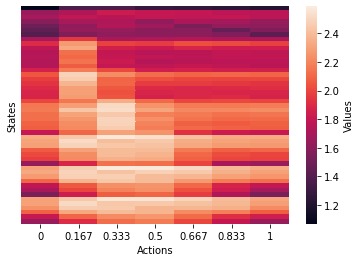

In [ ]:
# Create Heatmap Average Q-Table Firm 2
x_axis_labels = [0, 0.167, 0.333, 0.5, 0.667, 0.833, 1] # labels for x-axis
y_axis_labels = []

dataframe_average_q_table_2 = pd.DataFrame(average_q_table_2)
heatmap_firm2 = sn.heatmap(dataframe_average_q_table_2, xticklabels=x_axis_labels, yticklabels = y_axis_labels)
heatmap_firm2.set_xlabel('Actions', fontsize=10)
heatmap_firm2.set_ylabel('States', fontsize=10)
heatmap_firm2.collections[0].colorbar.set_label("Values")
plt.savefig(f"/content/drive/MyDrive/images/baseline/baseline_q_table_2.png")

**Average Prices and Profits Graphs**

In [ ]:
# prices firm 1
average_prices_firm1 = pd.DataFrame(average_data)[0]
# prices firm 2
average_prices_firm2 = pd.DataFrame(average_data)[1]
# profits firm 1
average_profits_firm1 = pd.DataFrame(average_data)[2]
# profits firm 2
average_profits_firm2 = pd.DataFrame(average_data)[3]

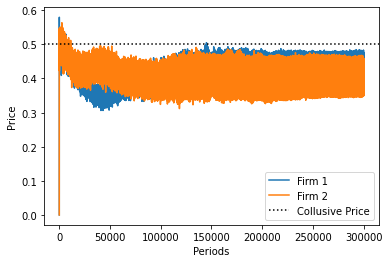

In [ ]:
# Create Graph Average Prices
x = np.arange(0, 300001)  

fig, ax = plt.subplots()
ax.plot(x, average_prices_firm1, label='Firm 1') 
ax.plot(x, average_prices_firm2, label='Firm 2') 
ax.set_xlabel('Periods')  
ax.set_ylabel('Price')  
plt.axhline(y=0.5, color='k', linestyle='dotted', label = 'Collusive Price')
ax.legend(); 
plt.savefig(f"/content/drive/MyDrive/images/baseline/baseline_average_prices.png")

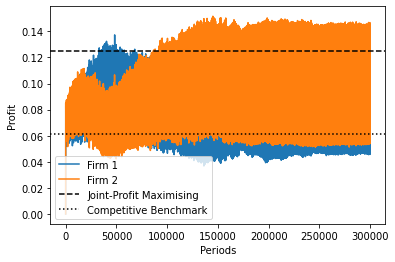

In [ ]:
# Create Graph Average Profits
x = np.arange(0, 300001)  

fig, ax = plt.subplots()
ax.plot(x, average_profits_firm1, label='Firm 1') 
ax.plot(x, average_profits_firm2, label='Firm 2') 
ax.set_xlabel('Periods')  
ax.set_ylabel('Profit') 
plt.axhline(y=0.125, color='k', linestyle='dashed', label = 'Joint-Profit Maximising')
plt.axhline(y=0.0611, color='k', linestyle= 'dotted', label = 'Competitive Benchmark')
ax.legend();
plt.savefig(f"/content/drive/MyDrive/images/baseline/baseline_average_profits.png")

**Get Data From Simultaneous Files**

In [ ]:
stacked_simultaneous_data = []
stacked_final_profitability_simultaneous_firm1 = []
stacked_final_profitability_simultaneous_firm2 = []

for run in trange(100):
  simultaneous_data_runs = pd.read_csv(f"/content/drive/MyDrive/simultaneous_files/Data_Run{run+1}.csv").drop(columns = ["Unnamed: 0"])
  stacked_simultaneous_data.append(simultaneous_data_runs)

  # Calculate Final Profitability for every run
  final_profitability_simultaneous_firm1 = np.mean(simultaneous_data_runs[-1000:], axis = 0)[2]
  stacked_final_profitability_simultaneous_firm1.append(final_profitability_simultaneous_firm1)

  final_profitability_simultaneous_firm2 = np.mean(simultaneous_data_runs[-1000:], axis = 0)[3]
  stacked_final_profitability_simultaneous_firm2.append(final_profitability_simultaneous_firm2)

average_simultaneous_data = np.mean(stacked_simultaneous_data, axis = 0)
del stacked_simultaneous_data

100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


In [ ]:
count_highest_profitability_simultaneous_firm1 = sum(x > y for x,y in zip(stacked_final_profitability_simultaneous_firm1, stacked_final_profitability_simultaneous_firm2))
print(f"Out of the 100 runs, firm 1 had the highest final profitability in {count_highest_profitability_simultaneous_firm1} of the cases")

count_highest_profitability_simultaneous_firm2 = sum(x > y for x,y in zip(stacked_final_profitability_simultaneous_firm2, stacked_final_profitability_simultaneous_firm1))
print(f"Out of the 100 runs, firm 2 had the highest final profitability in {count_highest_profitability_simultaneous_firm2} of the cases")

count_same_profitability_simultaneous = sum(x == y for x, y in zip(stacked_final_profitability_simultaneous_firm1, stacked_final_profitability_simultaneous_firm2))
print(f"Out of the 100 runs, firm 1 and 2 had the same final profitability in {count_same_profitability_simultaneous} of the cases")

Out of the 100 runs, firm 1 had the highest final profitability in 41 of the cases
Out of the 100 runs, firm 2 had the highest final profitability in 18 of the cases
Out of the 100 runs, firm 1 and 2 had the same final profitability in 41 of the cases


In [ ]:
# prices firm 1
simultaneous_average_prices_firm1 = pd.DataFrame(average_simultaneous_data)[0]
# prices firm 2
simultaneous_average_prices_firm2 = pd.DataFrame(average_simultaneous_data)[1]
# profits firm 1
simultaneous_average_profits_firm1 = pd.DataFrame(average_simultaneous_data)[2]
# profits firm 2
simultaneous_average_profits_firm2 = pd.DataFrame(average_simultaneous_data)[3]

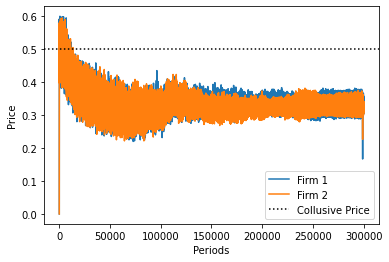

In [ ]:
# Create Graph Average Prices
x = np.arange(0, 300001)  

fig, ax = plt.subplots()
ax.plot(x, simultaneous_average_prices_firm1, label='Firm 1') 
ax.plot(x, simultaneous_average_prices_firm2, label='Firm 2') 
ax.set_xlabel('Periods')  
plt.axhline(y=0.5, color='k', linestyle='dotted', label = 'Collusive Price')
ax.set_ylabel('Price') 
ax.legend(); 
plt.savefig(f"/content/drive/MyDrive/images/simultaneous/simultaneous_average_prices.png")

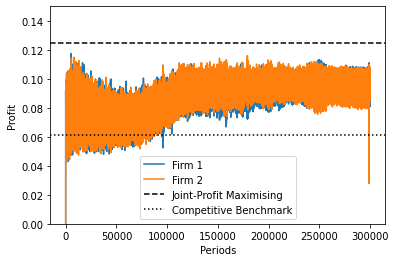

In [ ]:
# Create Graph Average Profits
x = np.arange(0, 300001)  

fig, ax = plt.subplots()
ax.plot(x, simultaneous_average_profits_firm1, label='Firm 1') 
ax.plot(x, simultaneous_average_profits_firm2, label='Firm 2') 
ax.set_xlabel('Periods')  
ax.set_ylabel('Profit')   
plt.axhline(y=0.125, color='k', linestyle='dashed', label = 'Joint-Profit Maximising')
plt.axhline(y=0.0611, color='k', linestyle= 'dotted', label = 'Competitive Benchmark')
plt.ylim(0, 0.15)
ax.legend();
plt.savefig(f"/content/drive/MyDrive/images/simultaneous/simultaneous_average_profits.png")

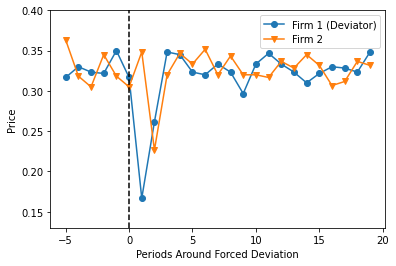

In [ ]:
# Create Graph Forced Deviation Prices
x = np.arange(0, 25)-5  

fig, ax = plt.subplots()
ax.plot(x, average_simultaneous_data[298995:299020,0], label='Firm 1 (Deviator)', marker = 'o') 
ax.plot(x, average_simultaneous_data[298995:299020,1], label='Firm 2', marker = 'v') 
ax.set_xlabel('Periods Around Forced Deviation')  
ax.set_ylabel('Price') 
ax.legend() 
plt.ylim(0.13, 0.4)
plt.axvline(x = 0, color = 'k', linestyle = 'dashed', label = 'axvline - full height')
plt.savefig(f"/content/drive/MyDrive/images/simultaneous/simultaneous_forced_deviation_prices.png")

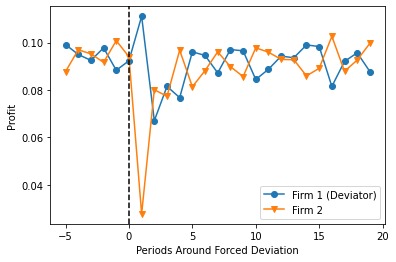

In [ ]:
# Create Graph Forced Deviation Profits
x = np.arange(0, 25)-5

fig, ax = plt.subplots()
ax.plot(x, average_simultaneous_data[298995:299020,2], label='Firm 1 (Deviator)', marker = 'o') 
ax.plot(x, average_simultaneous_data[298995:299020,3], label='Firm 2', marker = 'v') 
ax.set_xlabel('Periods Around Forced Deviation')  
ax.set_ylabel('Profit') 
ax.legend(); 
plt.axvline(x = 0, color = 'k', linestyle = 'dashed', label = 'axvline - full height')
plt.savefig(f"/content/drive/MyDrive/images/simultaneous/simultaneous_forced_deviation_profits.png")

**Get Data From Sequential Files**

In [ ]:
stacked_sequential_data = []
stacked_final_profitability_sequential_firm1 = []
stacked_final_profitability_sequential_firm2 = []

for run in trange(100):
  sequential_data_runs = pd.read_csv(f"/content/drive/MyDrive/sequential_files/Data_Run{run+1}.csv").drop(columns = ["Unnamed: 0"])
  stacked_sequential_data.append(sequential_data_runs)

  # Calculate Final Profitability for every run
  final_profitability_sequential_firm1 = np.mean(sequential_data_runs[-1000:], axis = 0)[2]
  stacked_final_profitability_sequential_firm1.append(final_profitability_sequential_firm1)

  final_profitability_sequential_firm2 = np.mean(sequential_data_runs[-1000:], axis = 0)[3]
  stacked_final_profitability_sequential_firm2.append(final_profitability_sequential_firm2)

average_sequential_data = np.mean(stacked_sequential_data, axis = 0)
del stacked_sequential_data

100%|██████████| 100/100 [01:08<00:00,  1.45it/s]


In [ ]:
count_highest_profitability_sequential_firm1 = sum(x > y for x,y in zip(stacked_final_profitability_sequential_firm1, stacked_final_profitability_sequential_firm2))
print(f"Out of the 100 runs, firm 1 had the highest final profitability in {count_highest_profitability_sequential_firm1} of the cases")

count_highest_profitability_sequential_firm2 = sum(x > y for x,y in zip(stacked_final_profitability_sequential_firm2, stacked_final_profitability_sequential_firm1))
print(f"Out of the 100 runs, firm 2 had the highest final profitability in {count_highest_profitability_sequential_firm2} of the cases")

count_same_profitability_sequential = sum(x == y for x, y in zip(stacked_final_profitability_sequential_firm1, stacked_final_profitability_sequential_firm2))
print(f"Out of the 100 runs, firm 1 and 2 had the same final profitability in {count_same_profitability_sequential} of the cases")

Out of the 100 runs, firm 1 had the highest final profitability in 59 of the cases
Out of the 100 runs, firm 2 had the highest final profitability in 23 of the cases
Out of the 100 runs, firm 1 and 2 had the same final profitability in 18 of the cases


In [ ]:
# prices firm 1
sequential_average_prices_firm1 = pd.DataFrame(average_sequential_data)[0]
# prices firm 2
sequential_average_prices_firm2 = pd.DataFrame(average_sequential_data)[1]
# profits firm 1
sequential_average_profits_firm1 = pd.DataFrame(average_sequential_data)[2]
# profits firm 2
sequential_average_profits_firm2 = pd.DataFrame(average_sequential_data)[3]

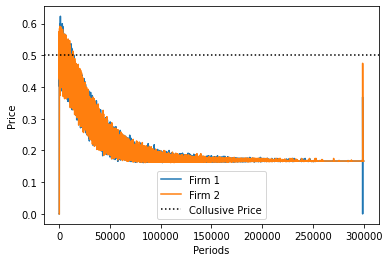

In [ ]:
# Create Graph Average Prices
x = np.arange(0, 300001)  

fig, ax = plt.subplots()
ax.plot(x, sequential_average_prices_firm1, label='Firm 1') 
ax.plot(x, sequential_average_prices_firm2, label='Firm 2') 
ax.set_xlabel('Periods') 
plt.axhline(y=0.5, color='k', linestyle='dotted', label = 'Collusive Price') 
ax.set_ylabel('Price') 
ax.legend(); 
plt.savefig(f"/content/drive/MyDrive/images/sequential/sequential_average_prices.png")

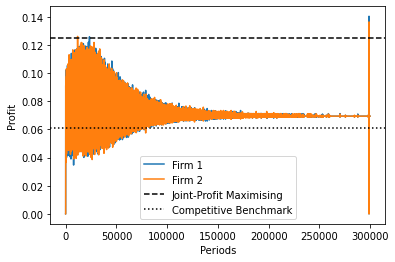

In [ ]:
# Create Graph Average Profits
x = np.arange(0, 300001)  

fig, ax = plt.subplots()
ax.plot(x, sequential_average_profits_firm1, label='Firm 1') 
ax.plot(x, sequential_average_profits_firm2, label='Firm 2') 
ax.set_xlabel('Periods')  
ax.set_ylabel('Profit') 
plt.axhline(y=0.125, color='k', linestyle='dashed', label = 'Joint-Profit Maximising')
plt.axhline(y=0.0611, color='k', linestyle= 'dotted', label = 'Competitive Benchmark')
ax.legend();
plt.savefig(f"/content/drive/MyDrive/images/sequential/sequential_average_profits.png")

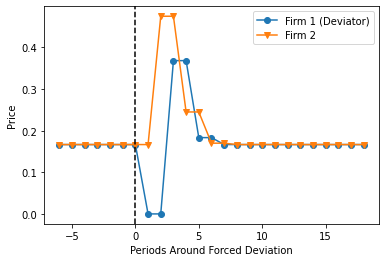

In [ ]:
# Create Graph Firm 1 Forced Deviation
x = np.arange(0, 25)-6  

fig, ax = plt.subplots()
ax.plot(x, sequential_average_prices_firm1[298995:299020], label='Firm 1 (Deviator)', marker = 'o') 
ax.plot(x, sequential_average_prices_firm2[298995:299020], label='Firm 2', marker = 'v') 
ax.set_xlabel('Periods Around Forced Deviation')  
ax.set_ylabel('Price') 
ax.legend(); 
plt.axvline(x = 0, color = 'k', linestyle = 'dashed', label = 'axvline - full height')
plt.savefig(f"/content/drive/MyDrive/images/sequential/sequential_forced_deviation_prices.png")

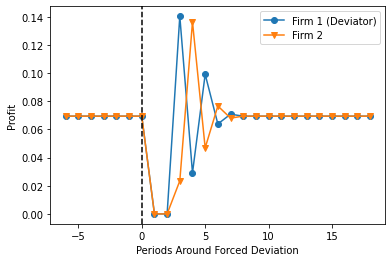

In [ ]:
# Create Graph Forced Deviation Profits
x = np.arange(0, 25)-6

fig, ax = plt.subplots()
ax.plot(x, sequential_average_profits_firm1[298995:299020], label='Firm 1 (Deviator)', marker = 'o') 
ax.plot(x, sequential_average_profits_firm2[298995:299020], label='Firm 2', marker = 'v') 
ax.set_xlabel('Periods Around Forced Deviation')  
ax.set_ylabel('Profit') 
ax.legend(); 
plt.axvline(x = 0, color = 'k', linestyle = 'dashed', label = 'axvline - full height')
plt.savefig(f"/content/drive/MyDrive/images/sequential/sequential_forced_deviation_profits.png")

**Graph Forced Deviation - Baseline (100 runs)** 

In [ ]:
# Get Data From Deviation Data
stacked_deviation_data = []
stacked_final_profitability_firm1 = []
stacked_final_profitability_firm2 = []

for run in trange(100):
  data_deviation_runs = pd.read_csv(f"/content/drive/MyDrive/deviation_files/Data_Run{run+1}.csv").drop(columns = ["Unnamed: 0"]).to_numpy()
  stacked_deviation_data.append(data_deviation_runs)

average_deviation_data = np.mean(stacked_deviation_data, axis = 0)

100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


In [ ]:
# prices firm 1
deviation_average_prices_firm1 = pd.DataFrame(average_deviation_data)[0]
# prices firm 2
deviation_average_prices_firm2 = pd.DataFrame(average_deviation_data)[1]
# profits firm 1
deviation_average_profits_firm1 = pd.DataFrame(average_deviation_data)[2]
# profits firm 2
deviation_average_profits_firm2 = pd.DataFrame(average_deviation_data)[3]

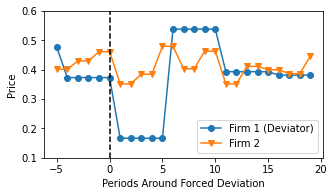

In [ ]:
# Deviation Prices Graph, Firm 1 forced deviation
x = np.arange(0, 25)-5  

fig, ax = plt.subplots(figsize=(5, 2.7))
ax.plot(x, deviation_average_prices_firm1[298995:299020], label='Firm 1 (Deviator)', marker = 'o') 
ax.plot(x, deviation_average_prices_firm2[298995:299020], label='Firm 2', marker = 'v') 
ax.set_xlabel('Periods Around Forced Deviation')  
ax.set_ylabel('Price')  
ax.legend()
plt.ylim(0.1, 0.6)
plt.axvline(x = 0, color = 'k', linestyle = 'dashed', label = 'axvline - full height')
fig.savefig(f"/content/drive/MyDrive/images/deviation/deviation_prices.png", dpi=300, bbox_inches = "tight")

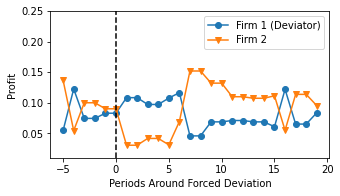

In [ ]:
# Deviation Profits Graph
x = np.arange(0, 25)-5  

fig, ax = plt.subplots(figsize=(5, 2.7))
ax.plot(x, deviation_average_profits_firm1[298995:299020], label='Firm 1 (Deviator)', marker = 'o') 
ax.plot(x, deviation_average_profits_firm2[298995:299020], label='Firm 2', marker = 'v') 
ax.set_xlabel('Periods Around Forced Deviation')  
ax.set_ylabel('Profit') 
ax.legend()
plt.ylim(0.01, 0.25)
plt.axvline(x = 0, color = 'k', linestyle = 'dashed', label = 'axvline - full height')
plt.savefig(f"/content/drive/MyDrive/images/deviation/deviation_profits.png", dpi=300, bbox_inches = "tight")

**Stochastic Frequency Setting**

In [6]:
stacked_stochastic_data = []
stacked_final_profitability_stochastic_firm1 = []
stacked_final_profitability_stochastic_firm2 = []

for run in trange(100):
  stochastic_data_runs = pd.read_csv(f"/content/drive/MyDrive/stochastic_files/Data_Run{run+1}.csv").drop(columns = ["Unnamed: 0"])
  stacked_stochastic_data.append(stochastic_data_runs)

  # Calculate Final Profitability for every run
  final_profitability_stochastic_firm1 = np.mean(stochastic_data_runs[-1000:], axis = 0)[2]
  stacked_final_profitability_stochastic_firm1.append(final_profitability_stochastic_firm1)

  final_profitability_stochastic_firm2 = np.mean(stochastic_data_runs[-1000:], axis = 0)[3]
  stacked_final_profitability_stochastic_firm2.append(final_profitability_stochastic_firm2)

average_stochastic_data = np.mean(stacked_stochastic_data, axis = 0)
del stacked_stochastic_data

100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


In [7]:
# prices firm 1
stochastic_average_prices_firm1 = pd.DataFrame(average_stochastic_data)[0]
# prices firm 2
stochastic_average_prices_firm2 = pd.DataFrame(average_stochastic_data)[1]
# profits firm 1
stochastic_average_profits_firm1 = pd.DataFrame(average_stochastic_data)[2]
# profits firm 2
stochastic_average_profits_firm2 = pd.DataFrame(average_stochastic_data)[3]

In [21]:
count_highest_profitability_stochastic_firm1 = sum(x > y for x,y in zip(stacked_final_profitability_stochastic_firm1, stacked_final_profitability_stochastic_firm2))
print(f"Out of the 100 runs, firm 1 had the highest final profitability in {count_highest_profitability_stochastic_firm1} of the cases")

count_highest_profitability_stochastic_firm2 = sum(x > y for x,y in zip(stacked_final_profitability_stochastic_firm2, stacked_final_profitability_stochastic_firm1))
print(f"Out of the 100 runs, firm 2 had the highest final profitability in {count_highest_profitability_stochastic_firm2} of the cases")

count_same_profitability_stochastic = sum(x == y for x, y in zip(stacked_final_profitability_stochastic_firm1, stacked_final_profitability_stochastic_firm2))
print(f"Out of the 100 runs, firm 1 and 2 had the same final profitability in {count_same_profitability_stochastic} of the cases")

Out of the 100 runs, firm 1 had the highest final profitability in 8 of the cases
Out of the 100 runs, firm 2 had the highest final profitability in 75 of the cases
Out of the 100 runs, firm 1 and 2 had the same final profitability in 17 of the cases


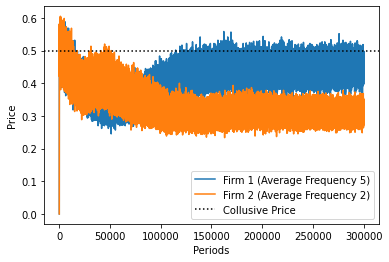

In [22]:
# Create Graph Average Prices
x = np.arange(0, 300001)  

fig, ax = plt.subplots()
ax.plot(x, stochastic_average_prices_firm1, label='Firm 1 (Average Frequency 5)') 
ax.plot(x, stochastic_average_prices_firm2, label='Firm 2 (Average Frequency 2)') 
ax.set_xlabel('Periods')  
ax.set_ylabel('Price') 
plt.axhline(y=0.5, color='k', linestyle= 'dotted', label = 'Collusive Price')
ax.legend()
plt.savefig(f"/content/drive/MyDrive/images/stochastic/stochastic_prices.png")

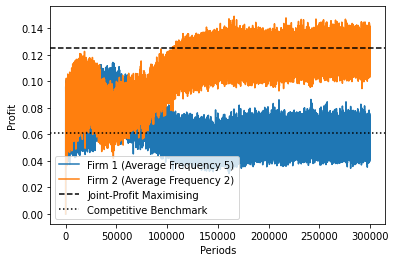

In [23]:
# Create Graph Average Profits
x = np.arange(0, 300001)  

fig, ax = plt.subplots()
ax.plot(x, stochastic_average_profits_firm1, label='Firm 1 (Average Frequency 5)') 
ax.plot(x, stochastic_average_profits_firm2, label='Firm 2 (Average Frequency 2)') 
ax.set_xlabel('Periods')  
ax.set_ylabel('Profit') 
plt.axhline(y=0.125, color='k', linestyle='dashed', label = 'Joint-Profit Maximising')
plt.axhline(y=0.0611, color='k', linestyle= 'dotted', label = 'Competitive Benchmark')
ax.legend()
plt.savefig(f"/content/drive/MyDrive/images/stochastic/stochastic_profits.png")

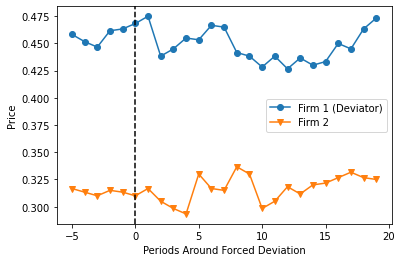

In [11]:
# Create Graph Prices around Forced Deviation
x = np.arange(0, 25)-5  

fig, ax = plt.subplots()
ax.plot(x, stochastic_average_prices_firm1[298995:299020], label='Firm 1 (Deviator)', marker = 'o') 
ax.plot(x, stochastic_average_prices_firm2[298995:299020], label='Firm 2', marker = 'v') 
ax.set_xlabel('Periods Around Forced Deviation')  
ax.set_ylabel('Price') 
ax.legend()
plt.axvline(x = 0, color = 'k', linestyle = 'dashed', label = 'axvline - full height')
plt.savefig(f"/content/drive/MyDrive/images/stochastic/stochastic_forced_deviation_prices.png", dpi=300, bbox_inches = "tight")

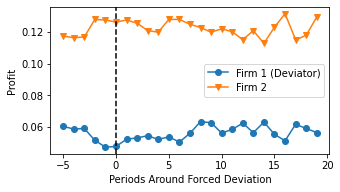

In [16]:
# Create Graph Profits around Forced Deviation
x = np.arange(0, 25)-5  

fig, ax = plt.subplots(figsize=(5, 2.7))
ax.plot(x, stochastic_average_profits_firm1[298995:299020], label='Firm 1 (Deviator)', marker = 'o') 
ax.plot(x, stochastic_average_profits_firm2[298995:299020], label='Firm 2', marker = 'v') 
ax.set_xlabel('Periods Around Forced Deviation')  
ax.set_ylabel('Profit') 
ax.legend()
plt.axvline(x = 0, color = 'k', linestyle = 'dashed', label = 'axvline - full height')
plt.savefig(f"/content/drive/MyDrive/images/stochastic/stochastic_forced_deviation_profits.png", dpi=300, bbox_inches = "tight")

**One Stochastic Firm**

In [4]:
stacked_one_stochastic_data = []
stacked_final_profitability_one_stochastic_firm1 = []
stacked_final_profitability_one_stochastic_firm2 = []

for run in trange(100):
  one_stochastic_data_runs = pd.read_csv(f"/content/drive/MyDrive/one_stochastic_files/Data_Run{run+1}.csv").drop(columns = ["Unnamed: 0"])
  stacked_one_stochastic_data.append(one_stochastic_data_runs)

  # Calculate Final Profitability for every run
  final_profitability_one_stochastic_firm1 = np.mean(one_stochastic_data_runs[-1000:], axis = 0)[2]
  stacked_final_profitability_one_stochastic_firm1.append(final_profitability_one_stochastic_firm1)

  final_profitability_one_stochastic_firm2 = np.mean(one_stochastic_data_runs[-1000:], axis = 0)[3]
  stacked_final_profitability_one_stochastic_firm2.append(final_profitability_one_stochastic_firm2)

average_one_stochastic_data = np.mean(stacked_one_stochastic_data, axis = 0)
del stacked_one_stochastic_data

100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


In [ ]:
count_highest_profitability_one_stochastic_firm1 = sum(x > y for x,y in zip(stacked_final_profitability_one_stochastic_firm1, stacked_final_profitability_one_stochastic_firm2))
print(f"Out of the 100 runs, firm 1 had the highest final profitability in {count_highest_profitability_one_stochastic_firm1} of the cases")

count_highest_profitability_one_stochastic_firm2 = sum(x > y for x,y in zip(stacked_final_profitability_one_stochastic_firm2, stacked_final_profitability_one_stochastic_firm1))
print(f"Out of the 100 runs, firm 2 had the highest final profitability in {count_highest_profitability_one_stochastic_firm2} of the cases")

count_same_profitability_one_stochastic = sum(x == y for x, y in zip(stacked_final_profitability_one_stochastic_firm1, stacked_final_profitability_one_stochastic_firm2))
print(f"Out of the 100 runs, firm 1 and 2 had the same final profitability in {count_same_profitability_one_stochastic} of the cases")

Out of the 100 runs, firm 1 had the highest final profitability in 89 of the cases
Out of the 100 runs, firm 2 had the highest final profitability in 11 of the cases
Out of the 100 runs, firm 1 and 2 had the same final profitability in 0 of the cases


In [6]:
# prices firm 1
one_stochastic_average_prices_firm1 = pd.DataFrame(average_one_stochastic_data)[0]
# prices firm 2
one_stochastic_average_prices_firm2 = pd.DataFrame(average_one_stochastic_data)[1]
# profits firm 1
one_stochastic_average_profits_firm1 = pd.DataFrame(average_one_stochastic_data)[2]
# profits firm 2
one_stochastic_average_profits_firm2 = pd.DataFrame(average_one_stochastic_data)[3]

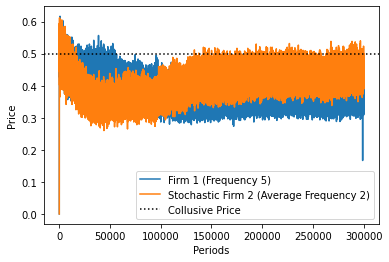

In [ ]:
# Create Graph Average Prices
x = np.arange(0, 300001)  

fig, ax = plt.subplots()
ax.plot(x, one_stochastic_average_prices_firm1, label='Firm 1 (Frequency 5)') 
ax.plot(x, one_stochastic_average_prices_firm2, label='Stochastic Firm 2 (Average Frequency 2)') 
ax.set_xlabel('Periods')  
ax.set_ylabel('Price') 
plt.axhline(y=0.5, color='k', linestyle= 'dotted', label = 'Collusive Price')
ax.legend()
plt.savefig(f"/content/drive/MyDrive/images/one_stochastic/one_stochastic_prices.png")

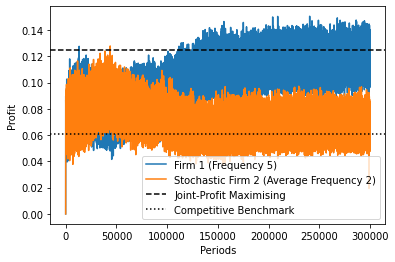

In [7]:
# Create Graph Average Profits
x = np.arange(0, 300001)  

fig, ax = plt.subplots()
ax.plot(x, one_stochastic_average_profits_firm1, label='Firm 1 (Frequency 5)') 
ax.plot(x, one_stochastic_average_profits_firm2, label='Stochastic Firm 2 (Average Frequency 2)') 
ax.set_xlabel('Periods')  
ax.set_ylabel('Profit')  
plt.axhline(y=0.125, color='k', linestyle='dashed', label = 'Joint-Profit Maximising')
plt.axhline(y=0.0611, color='k', linestyle= 'dotted', label = 'Competitive Benchmark')
ax.legend()
plt.savefig(f"/content/drive/MyDrive/images/one_stochastic/one_stochastic_profits.png")

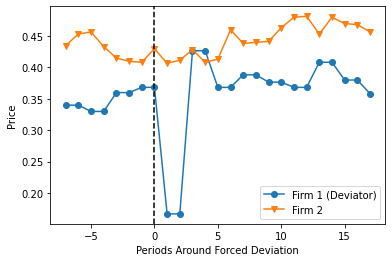

In [ ]:
# Create Graph Prices around Forced Deviation
x = np.arange(0, 25)-7  

fig, ax = plt.subplots()
ax.plot(x, one_stochastic_average_prices_firm1[298995:299020], label='Firm 1 (Deviator)', marker = 'o') 
ax.plot(x, one_stochastic_average_prices_firm2[298995:299020], label='Firm 2', marker = 'v') 
ax.set_xlabel('Periods Around Forced Deviation')  
ax.set_ylabel('Price') 
ax.legend()
plt.axvline(x = 0, color = 'k', linestyle = 'dashed', label = 'axvline - full height')
plt.savefig(f"/content/drive/MyDrive/images/one_stochastic/one_stochastic_forced_deviation_prices.png")

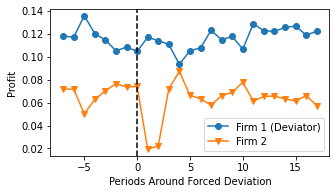

In [ ]:
# Create Graph Profits around Forced Deviation
x = np.arange(0, 25)-7 

fig, ax = plt.subplots(figsize=(5, 2.7))
ax.plot(x, one_stochastic_average_profits_firm1[298995:299020], label='Firm 1 (Deviator)', marker = 'o') 
ax.plot(x, one_stochastic_average_profits_firm2[298995:299020], label='Firm 2', marker = 'v') 
ax.set_xlabel('Periods Around Forced Deviation')  
ax.set_ylabel('Profit')  
ax.legend()
plt.axvline(x = 0, color = 'k', linestyle = 'dashed', label = 'axvline - full height')
plt.savefig(f"/content/drive/MyDrive/images/one_stochastic/one_stochastic_forced_deviation_profits.png", dpi=300, bbox_inches = "tight")

**Final Profitability For Different Frequency Differences**

In [ ]:
stacked_twotwo_data = []
stacked_final_profitability_twotwo_firm1 = []
stacked_final_profitability_twotwo_firm2 = []

stacked_threetwo_data = []
stacked_final_profitability_threetwo_firm1 = []
stacked_final_profitability_threetwo_firm2 = []

stacked_fivetwo_data = []
stacked_final_profitability_fivetwo_firm1 = []
stacked_final_profitability_fivetwo_firm2 = []

stacked_seventwo_data = []
stacked_final_profitability_seventwo_firm1 = []
stacked_final_profitability_seventwo_firm2 = []

stacked_ninetwo_data = []
stacked_final_profitability_ninetwo_firm1 = []
stacked_final_profitability_ninetwo_firm2 = []

stacked_eleventwo_data = []
stacked_final_profitability_eleventwo_firm1 = []
stacked_final_profitability_eleventwo_firm2 = []

stacked_thirteentwo_data = []
stacked_final_profitability_thirteentwo_firm1 = []
stacked_final_profitability_thirteentwo_firm2 = []

stacked_fifteentwo_data = []
stacked_final_profitability_fifteentwo_firm1 = []
stacked_final_profitability_fifteentwo_firm2 = []

stacked_seventeentwo_data = []
stacked_final_profitability_seventeentwo_firm1 = []
stacked_final_profitability_seventeentwo_firm2 = []

for run in trange(100):
  twotwo_data_runs = pd.read_csv(f"/content/drive/MyDrive/2_and_2_files/Data_Run{run+1}.csv").drop(columns = ["Unnamed: 0"])

  threetwo_data_runs = pd.read_csv(f"/content/drive/MyDrive/3_and_2_files/Data_Run{run+1}.csv").drop(columns = ["Unnamed: 0"])

  fivetwo_data_runs = pd.read_csv(f"/content/drive/MyDrive/baseline_files/Data_Run{run+1}.csv").drop(columns = ["Unnamed: 0"])
  
  seventwo_data_runs = pd.read_csv(f"/content/drive/MyDrive/7_and_2_files/Data_Run{run+1}.csv").drop(columns = ["Unnamed: 0"])

  ninetwo_data_runs = pd.read_csv(f"/content/drive/MyDrive/9_and_2_files/Data_Run{run+1}.csv").drop(columns = ["Unnamed: 0"])

  eleventwo_data_runs = pd.read_csv(f"/content/drive/MyDrive/11_and_2_files/Data_Run{run+1}.csv").drop(columns = ["Unnamed: 0"])

  thirteentwo_data_runs = pd.read_csv(f"/content/drive/MyDrive/13_and_2_files/Data_Run{run+1}.csv").drop(columns = ["Unnamed: 0"])

  fifteentwo_data_runs = pd.read_csv(f"/content/drive/MyDrive/15_and_2_files/Data_Run{run+1}.csv").drop(columns = ["Unnamed: 0"])

  seventeentwo_data_runs = pd.read_csv(f"/content/drive/MyDrive/17_and_2_files/Data_Run{run+1}.csv").drop(columns = ["Unnamed: 0"])
  
  # Calculate Final Profitability for very run
  # 2 and 2
  final_profitability_twotwo_firm1 = np.mean(twotwo_data_runs[-1000:], axis = 0)[2]
  stacked_final_profitability_twotwo_firm1.append(final_profitability_twotwo_firm1)

  final_profitability_twotwo_firm2 = np.mean(twotwo_data_runs[-1000:], axis = 0)[3]
  stacked_final_profitability_twotwo_firm2.append(final_profitability_twotwo_firm2)

  # 3 and 2
  final_profitability_threetwo_firm1 = np.mean(threetwo_data_runs[-1000:], axis = 0)[2]
  stacked_final_profitability_threetwo_firm1.append(final_profitability_threetwo_firm1)

  final_profitability_threetwo_firm2 = np.mean(threetwo_data_runs[-1000:], axis = 0)[3]
  stacked_final_profitability_threetwo_firm2.append(final_profitability_threetwo_firm2)

  # 5 and 2
  final_profitability_fivetwo_firm1 = np.mean(fivetwo_data_runs[-1000:], axis = 0)[2]
  stacked_final_profitability_fivetwo_firm1.append(final_profitability_fivetwo_firm1)

  final_profitability_fivetwo_firm2 = np.mean(fivetwo_data_runs[-1000:], axis = 0)[3]
  stacked_final_profitability_fivetwo_firm2.append(final_profitability_fivetwo_firm2)
  
  # 7 and 2
  final_profitability_seventwo_firm1 = np.mean(seventwo_data_runs[-1000:], axis = 0)[2]
  stacked_final_profitability_seventwo_firm1.append(final_profitability_seventwo_firm1)

  final_profitability_seventwo_firm2 = np.mean(seventwo_data_runs[-1000:], axis = 0)[3]
  stacked_final_profitability_seventwo_firm2.append(final_profitability_seventwo_firm2)

  # 9 and 2
  final_profitability_ninetwo_firm1 = np.mean(ninetwo_data_runs[-1000:], axis = 0)[2]
  stacked_final_profitability_ninetwo_firm1.append(final_profitability_ninetwo_firm1)

  final_profitability_ninetwo_firm2 = np.mean(ninetwo_data_runs[-1000:], axis = 0)[3]
  stacked_final_profitability_ninetwo_firm2.append(final_profitability_ninetwo_firm2)

  # 11 and 2
  final_profitability_eleventwo_firm1 = np.mean(eleventwo_data_runs[-1000:], axis = 0)[2]
  stacked_final_profitability_eleventwo_firm1.append(final_profitability_eleventwo_firm1)

  final_profitability_eleventwo_firm2 = np.mean(eleventwo_data_runs[-1000:], axis = 0)[3]
  stacked_final_profitability_eleventwo_firm2.append(final_profitability_eleventwo_firm2)

  # 13 and 2
  final_profitability_thirteentwo_firm1 = np.mean(thirteentwo_data_runs[-1000:], axis = 0)[2]
  stacked_final_profitability_thirteentwo_firm1.append(final_profitability_thirteentwo_firm1)

  final_profitability_thirteentwo_firm2 = np.mean(thirteentwo_data_runs[-1000:], axis = 0)[3]
  stacked_final_profitability_thirteentwo_firm2.append(final_profitability_thirteentwo_firm2)

  # 15 and 2
  final_profitability_fifteentwo_firm1 = np.mean(fifteentwo_data_runs[-1000:], axis = 0)[2]
  stacked_final_profitability_fifteentwo_firm1.append(final_profitability_fifteentwo_firm1)

  final_profitability_fifteentwo_firm2 = np.mean(fifteentwo_data_runs[-1000:], axis = 0)[3]
  stacked_final_profitability_fifteentwo_firm2.append(final_profitability_fifteentwo_firm2)

  # 17 and 2
  final_profitability_seventeentwo_firm1 = np.mean(seventeentwo_data_runs[-1000:], axis = 0)[2]
  stacked_final_profitability_seventeentwo_firm1.append(final_profitability_seventeentwo_firm1)

  final_profitability_seventeentwo_firm2 = np.mean(seventeentwo_data_runs[-1000:], axis = 0)[3]
  stacked_final_profitability_seventeentwo_firm2.append(final_profitability_seventeentwo_firm2)


100%|██████████| 100/100 [07:43<00:00,  4.64s/it]


In [ ]:
# Average Final Profitablity for 100 runs
#firm 1 (2) and firm 2 (2)
average_twotwo_firm1 = np.mean(stacked_final_profitability_twotwo_firm1)
average_twotwo_firm2 = np.mean(stacked_final_profitability_twotwo_firm2)

#firm 1 (3) and firm 2 (2)
average_threetwo_firm1 = np.mean(stacked_final_profitability_threetwo_firm1)
average_threetwo_firm2 = np.mean(stacked_final_profitability_threetwo_firm2)

#firm 1 (5) and firm 2 (2)
average_fivetwo_firm1 = np.mean(stacked_final_profitability_fivetwo_firm1)
average_fivetwo_firm2 = np.mean(stacked_final_profitability_fivetwo_firm2)

#firm 1 (7) and firm 2 (2)
average_seventwo_firm1 = np.mean(stacked_final_profitability_seventwo_firm1)
average_seventwo_firm2 = np.mean(stacked_final_profitability_seventwo_firm2)

# firm 1 (9) and firm 2 (2)
average_ninetwo_firm1 = np.mean(stacked_final_profitability_ninetwo_firm1)
average_ninetwo_firm2 = np.mean(stacked_final_profitability_ninetwo_firm2)

# firm 1 (11) and firm 2 (2)
average_eleventwo_firm1 = np.mean(stacked_final_profitability_eleventwo_firm1)
average_eleventwo_firm2 = np.mean(stacked_final_profitability_eleventwo_firm2)

# firm 1 (13) and firm 2 (2)
average_thirteentwo_firm1 = np.mean(stacked_final_profitability_thirteentwo_firm1)
average_thirteentwo_firm2 = np.mean(stacked_final_profitability_thirteentwo_firm2)

# firm 1 (15) and firm 2 (2)
average_fifteentwo_firm1 = np.mean(stacked_final_profitability_fifteentwo_firm1)
average_fifteentwo_firm2 = np.mean(stacked_final_profitability_fifteentwo_firm2)

# firm 1 (17) and firm 2 (2)
average_seventeentwo_firm1 = np.mean(stacked_final_profitability_seventeentwo_firm1)
average_seventeentwo_firm2 = np.mean(stacked_final_profitability_seventeentwo_firm2)

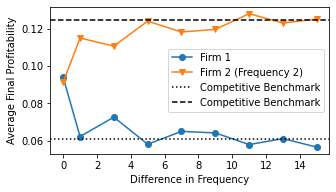

In [ ]:
# Deviation Profits Graph
x = [0, 1, 3, 5, 7, 9, 11, 13, 15] 

average_final_firm1 = [average_twotwo_firm1, average_threetwo_firm1, average_fivetwo_firm1, average_seventwo_firm1, average_ninetwo_firm1, average_eleventwo_firm1, average_thirteentwo_firm1, average_fifteentwo_firm1, average_seventeentwo_firm1]
average_final_firm2 = [average_twotwo_firm2, average_threetwo_firm2, average_fivetwo_firm2, average_seventwo_firm2, average_ninetwo_firm2, average_eleventwo_firm2, average_thirteentwo_firm2, average_fifteentwo_firm2, average_seventeentwo_firm2]

fig, ax = plt.subplots(figsize=(5, 2.7))
ax.plot(x, average_final_firm1, label='Firm 1', marker = 'o') 
ax.plot(x, average_final_firm2, label='Firm 2 (Frequency 2)', marker = 'v') 
ax.set_xlabel('Difference in Frequency')  
ax.set_ylabel('Average Final Profitability') 
plt.axhline(y=0.0611, color='k', linestyle= 'dotted', label = 'Competitive Benchmark')
plt.axhline(y=0.125, color='k', linestyle= 'dashed', label = 'Competitive Benchmark')
ax.legend()
plt.savefig(f"/content/drive/MyDrive/images/final_profitability.png", dpi=300, bbox_inches = "tight")